<a href="https://colab.research.google.com/github/jslee938/HAI_1st_summer_HW_/blob/main/HAI_summer_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import random
from glob import glob
from PIL import Image
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torchvision.transforms as T
from torchvision.transforms import ToPILImage

In [7]:
#A

drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device : {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device : cpu


In [8]:
#B

class DIV2K_Dataset(Dataset):
    def __init__(self, imgs, crop_size=64, upscale_factor=2):
        self.imgs = imgs
        self.crop_size = crop_size
        self.upscale_factor = upscale_factor

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, i):
        x, y = self.__transform__(i)
        return x, y

    def __transform__(self, i):
        p = self.imgs[i]
        img = Image.open(p).convert("RGB")
        x = T.CenterCrop(self.crop_size)(img)
        rate = self.crop_size // self.upscale_factor
        x_size = (rate, rate)
        y = TF.resize(x, x_size, interpolation=Image.BICUBIC)
        y = TF.resize(y, (self.crop_size, self.crop_size), interpolation=Image.BICUBIC)
        x_t = TF.to_tensor(x)
        y_t = TF.to_tensor(y)
        return x_t, y_t

DATA_ROOT = '/content/drive/MyDrive/DIV2K_519sampled/DIV2K_519sampled'
all_imgs = [os.path.join(DATA_ROOT, f) for f in os.listdir(DATA_ROOT) if f.lower().endswith(('.png'))]
print(f"Found {len(all_imgs)} images.")

random.shuffle(all_imgs)
train_imgs = all_imgs[:363]
val_imgs = all_imgs[363:363 + 104]
test_imgs = all_imgs[363 + 104:363 + 104 + 52]

print(f"Train images: {len(train_imgs)}")
print(f"Validation images: {len(val_imgs)}")
print(f"Test images: {len(test_imgs)}")

train_ds = DIV2K_Dataset(train_imgs)
val_ds = DIV2K_Dataset(val_imgs)
test_ds = DIV2K_Dataset(test_imgs)

Found 519 images.
Train images: 363
Validation images: 104
Test images: 52


In [9]:
#C

class SR_CNN(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.darknet = nn.Sequential(
            nn.Conv2d(in_channels, 64, 9, 1, 4),
            nn.ReLU(True),
            nn.Conv2d(64, 32, 1, 1, 0),
            nn.ReLU(True),
            nn.Conv2d(32, in_channels, 5, 1, 2)
        )

    def forward(self, x):
        return self.darknet(x)

In [10]:
#D

EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_WORKERS = os.cpu_count() // 2
model = SR_CNN().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=1)

train_losses = []
val_losses = []

best_val_loss = float('inf')
best_epoch = 0
best_model_state = None
best_optim_state = None

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0.0
    for lr_t, hr_t in train_loader:
        lr_t = lr_t.to(device)
        hr_t = hr_t.to(device)
        optimizer.zero_grad()
        out = model(lr_t)
        loss = loss_fn(out, hr_t)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * lr_t.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for lr_t, hr_t in val_loader:
            lr_t = lr_t.to(device)
            hr_t = hr_t.to(device)
            out = model(lr_t)
            loss = loss_fn(out, hr_t)
            val_loss += loss.item() * lr_t.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:02d}  Train loss: {train_loss:.6f}  Val loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.6f} to {val_loss:.6f}")
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = model.state_dict()
        best_optim_state = optimizer.state_dict()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01  Train loss: 0.063401  Val loss: 0.028081
Validation loss improved from inf to 0.028081
Epoch 02  Train loss: 0.021727  Val loss: 0.021553
Validation loss improved from 0.028081 to 0.021553
Epoch 03  Train loss: 0.017912  Val loss: 0.015221
Validation loss improved from 0.021553 to 0.015221
Epoch 04  Train loss: 0.012492  Val loss: 0.009130
Validation loss improved from 0.015221 to 0.009130
Epoch 05  Train loss: 0.007686  Val loss: 0.005764
Validation loss improved from 0.009130 to 0.005764
Epoch 06  Train loss: 0.005443  Val loss: 0.004876
Validation loss improved from 0.005764 to 0.004876
Epoch 07  Train loss: 0.004435  Val loss: 0.003917
Validation loss improved from 0.004876 to 0.003917
Epoch 08  Train loss: 0.004035  Val loss: 0.004265
Epoch 09  Train loss: 0.004069  Val loss: 0.002774
Validation loss improved from 0.003917 to 0.002774
Epoch 10  Train loss: 0.003209  Val loss: 0.002572
Validation loss improved from 0.002774 to 0.002572
Epoch 11  Train loss: 0.002694  Val 

In [11]:
#E

CHECKPOINT_PATH = "srcnn_checkpoint.pth"
print(f"Best epoch: {best_epoch}")
print(f"Best validation loss: {best_val_loss}")
torch.save({
    'epoch': best_epoch,
    'model_state_dict': best_model_state,
    'optimizer_state_dict': best_optim_state,
    'loss': best_val_loss,
}, CHECKPOINT_PATH)
ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
new_model = SR_CNN().to(device)
new_model.load_state_dict(ckpt["model_state_dict"])
new_model.to(device).eval()

Best epoch: 50
Best validation loss: 0.0003059253033895332


SR_CNN(
  (darknet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

Random index: 45


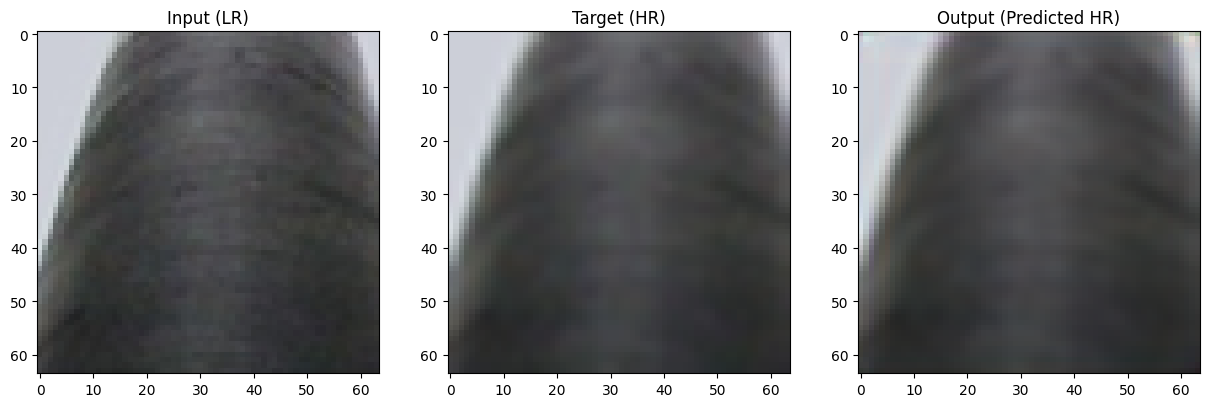

In [12]:
save_dir = "drive/MyDrive/content/SR_outputs/"
os.makedirs(save_dir, exist_ok=True)

with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        inputs, targets = batch[0].to(device), batch[1].to(device)
        outputs = new_model(inputs)

        for i in range(outputs.size(0)):
            output_img = outputs[i].cpu().clamp(0.0, 1.0)
            tmp = idx * test_loader.batch_size + i + 1
            if tmp // 10 != 0:
              save_path = os.path.join(save_dir, f"SR_output_{idx * test_loader.batch_size + i + 1}.png")
            else:
              save_path = os.path.join(save_dir, f"SR_output_0{idx * test_loader.batch_size + i + 1}.png")
            TF.to_pil_image(output_img).save(save_path)

random_idx = random.randint(0, len(test_ds) - 1)
print(f"Random index: {random_idx}")
input, target = test_ds[random_idx]
output = new_model(input.unsqueeze(0).to(device))
output = output.squeeze(0).cpu().detach()
output = output.clamp(0.0, 1.0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(TF.to_pil_image(input))
plt.title("Input (LR)")

plt.subplot(1, 3, 2)
plt.imshow(TF.to_pil_image(target))
plt.title("Target (HR)")

plt.subplot(1, 3, 3)
plt.imshow(TF.to_pil_image(output))
plt.title("Output (Predicted HR)")

plt.show()